# Datapaper plots

1. field_location.png Modis moa Inset map, ant in corner, icestreams scale, square of common border, include flow route,
2. geophysics_overview.png Map of all data presented
3. historic_channel.png Historic landsat images
4. thickness_surfacecolour.png Profile depth
5. 4square_channel.png Four square = imagery, surface, bed&surface, change
6. 3D view of channel
7. radarlines 
8. channel_meander.png meander
11. ApRES include stress
9. Icesat1/REMA
10. Icesat2


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm
import rasterio as rio
from shapely.geometry import Point, LineString, Polygon, MultiPoint
import fiona
from shapely.ops import nearest_points
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
import matplotlib as mpl

In [2]:
xmin, xmax, ymin, ymax = -382700, -374781.9, -734075.1, -721770.2

In [3]:
xgrid = np.arange(-382000,-374000,2000)


## 4. thickness_surfacecolour.png
profile depth

In [4]:
x_new = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_line2line_interpbydist_points_x.npy')
y_new = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_line2line_interpbydist_points_y.npy')
it_new = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_line2line_interpbydist_ice_thickn.npy')
ib_new = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_line2line_interpbydist_icebase.npy')

In [5]:
#load REMA
nid1 = 159202
nid2 = 131226
df = gpd.read_file('/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/REMA_Strip_Index_Rel1/REMA_Strip_Index_Rel1.shp')
path = f"/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/DIFFERENCES/REMA_{nid1}-{nid2}_diff.tif"
# /Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/DIFFERENCES/REMA_159202-131226_diff.tif
f = df.loc[nid1].acquisitio
t =df.loc[nid2].acquisitio
duration = (pd.to_datetime(t)-pd.to_datetime(f)).days/365.25
with rio.open(path) as image:
    im = image.read(1)
    im[im==-9999] = np.nan
    im = im / duration
    extent_REMAdiff = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
with rio.open('/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/SETSM_WV01_20161109_1020010058134D00_10200100576C9100_seg1_2m_v1.0_dem.tif') as image:
    extent_REMA = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
    im_REMA = image.read(1)

In [6]:
df.loc[nid1].fileurl

'http://data.pgc.umn.edu/elev/dem/setsm/REMA/geocell/v1.0/2m/s83w153/SETSM_WV02_20121224_103001001D86CA00_103001001D886000_seg1_2m_v1.0.tar.gz'

In [7]:
direc = '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/interpolatedgrid_allchan'

xv = np.load(direc + 'x_grid' +'.npy')
yv = np.load(direc + 'y_grid' +'.npy')
thickness_interpolated = np.load(direc +'ice_thickness'+'.npy')
extent_l2l = np.load(direc +'extent.npy')
ice_base = np.load(direc +'_ice_base.npy')


In [8]:
x = np.linspace(extent_REMA[0],extent_REMA[1],im_REMA.shape[1]).astype('int')
y = np.linspace(extent_REMA[3],extent_REMA[2],im_REMA.shape[0]).astype('int')

In [9]:
# xmin, xmax, ymin, ymax = extent_l2l

In [10]:
# xmin = -382700

In [1]:
print(xmin, xmax, ymin, ymax)

NameError: name 'xmin' is not defined

## Plot it

In [12]:
it = it_new[50,:]
ib = ib_new[50,:]
x = x_new[50,:]
y = y_new[50,:]
mid = pd.DataFrame({'x': x,'y':y,'ice_thickn':it,'ice_base':ib})

points = [Point(xy) for xy in zip(mid.x,mid.y)]
gdf_mid = gpd.GeoDataFrame(mid,geometry=points,crs="EPSG:3031")

In [14]:
# mpl.rcParams['font.size']=10
# plt.figure(figsize=(10,10))
# plt.plot(x,it)
# plt.plot(points_x_surveyed[50,:],ice_thickn_surveyed[50,:],'x')
# plt.grid()
# plt.ylim(400,500)
# plt.show()

In [15]:
points_x_surveyed = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_points_x_channel.npy')
points_y_surveyed = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_points_y_channel.npy') 
ice_thickn_surveyed = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_ice_thickn_channel.npy')
base_surveyed = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_bed_channel.npy')

In [16]:
# plt.plot(x,np.mean(ib_new[5:15,:],0))

In [17]:
import pickle
with open('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/shapefiles/bullseye.pkl', "rb") as poly_file:
    bullseye = pickle.load(poly_file)

In [18]:
bullseye_array = np.array(bullseye.exterior.coords.xy )

In [19]:
# 12 original points with 399 inbeween

In [20]:
11*399+12

4401

In [21]:
tmp_dfp = [Point.distance(gdf_mid.geometry.iloc[i]) for i,Point in enumerate(gdf_mid.geometry.iloc[1:])]
tmp_dfp[:0] = [0]
gdf_mid['dx'] = pd.Series(tmp_dfp) #note the 1:, equivalent to i+1
gdf_mid['distan_cum'] = gdf_mid.dx.cumsum()

In [22]:
f = sp.interpolate.interp1d(gdf_mid.y,gdf_mid.distan_cum)

In [23]:
distan_cum_surveyed = f(points_y_surveyed[50,:])

In [24]:
gdf_mid['in_meltzone'] = gdf_mid.geometry.intersects(bullseye)
gdf_mz = gdf_mid[gdf_mid.in_meltzone==True].copy()

In [25]:
gdf_mid.to_file('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/shapefiles/mid_chan_interpd.shp')

/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


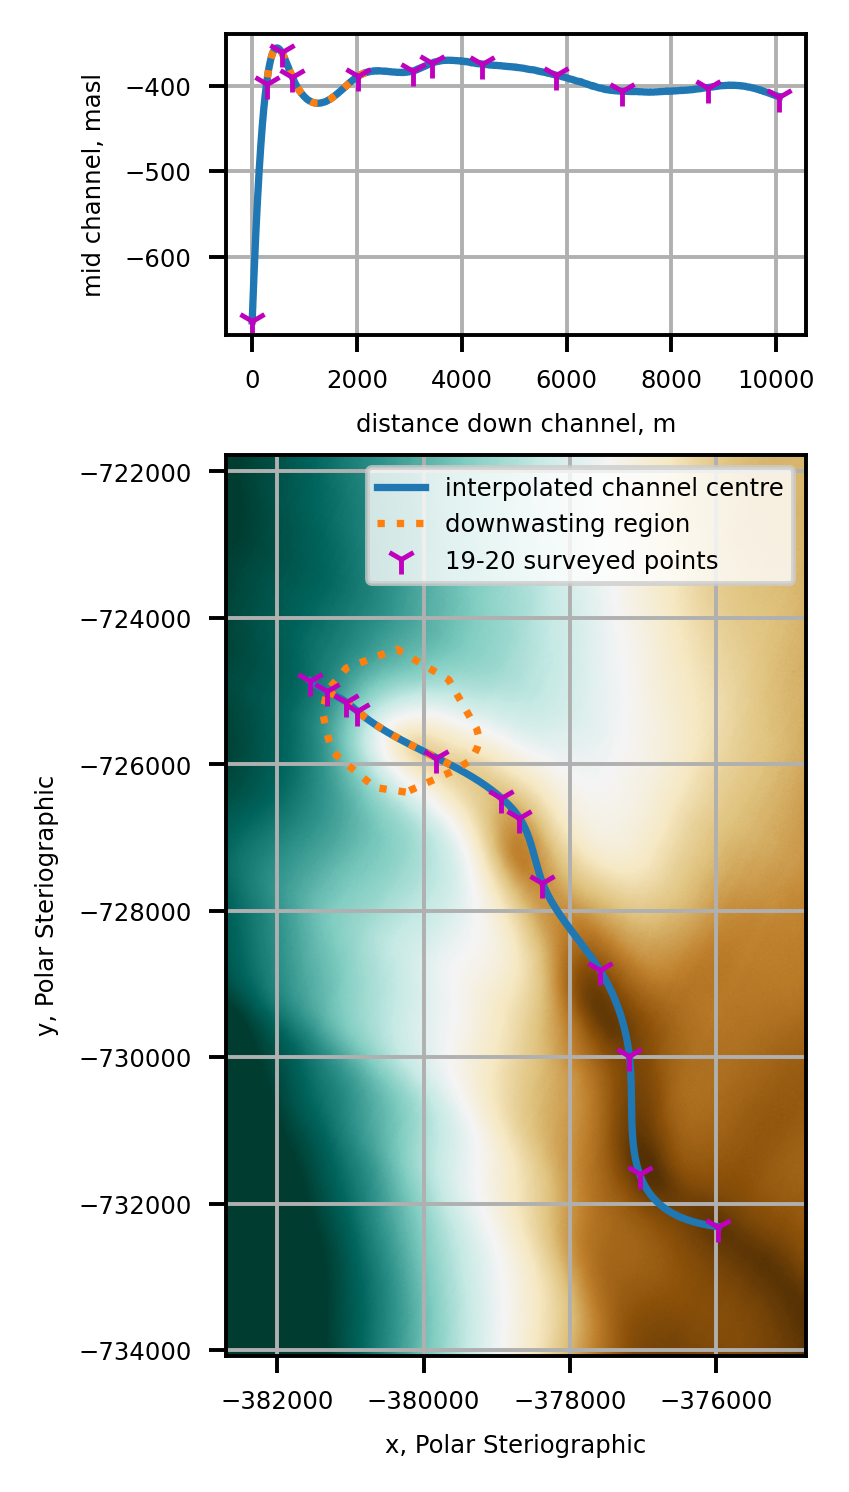

In [26]:
# %matplotlib qt
#  fug, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[2, 3]},figsize=(6,6),dpi=180)#rema

font = {'size'   : 5}

mpl.rc('font', **font)

fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[1, 3]},
                               figsize=(4,5),dpi=350)#rema ,constrained_layout=True


ax1.plot(gdf_mid.distan_cum,gdf_mid.ice_base)
# ax1.plot( gdf_mid.distan_cum.iloc[39],gdf_mid.ice_base.iloc[39],'b1',label="downwasting centre",markersize=15,markeredgewidth=2)
ax1.plot(gdf_mz.distan_cum,gdf_mz.ice_base,':',label="downwasting region",
         color='tab:orange') #,linewidth=3,markersize=15,markeredgewidth=2,
ax1.plot(distan_cum_surveyed,base_surveyed[50,:],'1',
          label="19-20 surveyed points",markersize=6,color="m")
# ax1.set_xlim([xmin, xmax])
# ax1.set_ylim([ymin,ymax])
ax1.set_ylabel('mid channel, masl')
ax1.set_xlabel('distance down channel, m')
ax1.grid()



ax2.imshow(im_REMA,extent=extent_REMA,vmin=25,vmax=80, cmap='BrBG')
ax2.plot( gdf_mid.x,gdf_mid.y,label='interpolated channel centre')
ax2.plot(bullseye_array[0],bullseye_array[1],':',label="downwasting region",color='tab:orange') #,markersize=15,markeredgewidth=2
ax2.plot(gdf_mz.x,gdf_mz.y,':',color='tab:orange') #,markersize=15,markeredgewidth=2
ax2.plot(points_x_surveyed[50,:],points_y_surveyed[50,:],'1',markersize=6,label="19-20 surveyed points",color="m")
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymin,ymax])
ax2.grid()
ax2.set_xlabel('x, Polar Steriographic')
ax2.set_ylabel('y, Polar Steriographic')
ax2.set_xticks(xgrid)
ax2.legend()

(x0, y0), (x1, y1) = ax2.get_position().get_points() 
(x20, y20), (x21, y21) = ax1.get_position().get_points() 
ax1.set_position([x0, y20, x1-x0,y21-y20 ])  # x, y, width, height


fig.savefig('/Users/home/whitefar/ASSIGNMENTS-PUBLICATIONS-TALKS/channel_data_writeup/PLOTS/thickness_surfacecolour.png')
fig.show()

In [27]:
ibb = np.mean(ib_new[45:55,:],axis=0)